Bayesian Statistics Made Simple
===

Code and exercises from my workshop on Bayesian statistics in Python.

Copyright 2018 Allen Downey

MIT License: https://opensource.org/licenses/MIT

In [1]:
# If we're running on Colab, install empiricaldist
# https://pypi.org/project/empiricaldist/

import sys
IN_COLAB = 'google.colab' in sys.modules

if IN_COLAB:
    !pip install empiricaldist

In [2]:
import numpy as np
import pandas as pd

import seaborn as sns
sns.set_style('white')
sns.set_context('talk')

import matplotlib.pyplot as plt

from empiricaldist import Pmf

### The Bayesian bandit problem

Suppose you have several "one-armed bandit" slot machines, and reason to think that they have different probabilities of paying off.

Each time you play a machine, you either win or lose, and you can use the outcome to update your belief about the probability of winning.

Then, to decide which machine to play next, you can use the "Bayesian bandit" strategy, explained below.

First, let's see how to do the update.

### The prior

If we know nothing about the probability of wining, we can start with a uniform prior.

In [3]:
def decorate_bandit(title):
    """Labels the axes.
    
    title: string
    """
    plt.xlabel('Probability of winning')
    plt.ylabel('PMF')
    plt.title(title)

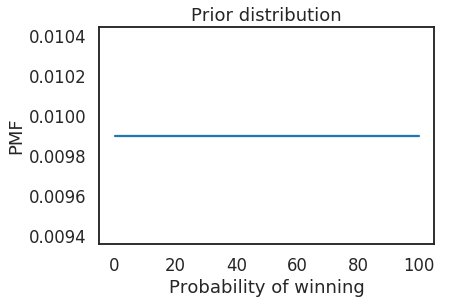

In [4]:
bandit = Pmf.from_seq(range(101))
bandit.plot()
decorate_bandit('Prior distribution')

In [7]:
bandit

,probs
0,0.009901
1,0.009901
2,0.009901
3,0.009901
4,0.009901
...,...
96,0.009901
97,0.009901
98,0.009901
99,0.009901


### The likelihood function

The likelihood function that computes the probability of an outcome (W or L) for a hypothetical value of x, the probability of winning (from 0 to 1).

In [8]:
def likelihood_bandit(data, hypo):
    """Likelihood function for Bayesian bandit
    
    data: string, either 'W' or 'L'
    hypo: probability of winning (0-100)
    
    returns: float probability
    """
    x = hypo / 100
    if data == 'W':
        return x
    else:
        return 1-x

**Exercise 1:** Suppose you play a machine 10 times and win once.  What is the posterior distribution of $x$?

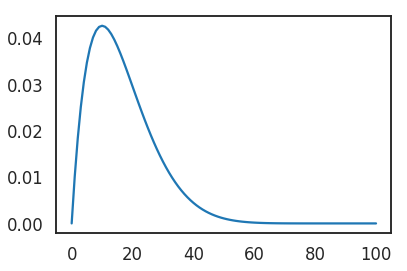

In [10]:
# Solution goes here
for g in 'LLLLLWLLLL':
    bandit.update(likelihood_bandit, g)

bandit.plot()

## Multiple bandits

Now suppose we have several bandits and we want to decide which one to play.

For this example, we have 4 machines with these probabilities:

In [22]:
actual_probs = [0.10, 0.20, 0.30, 0.40]

The function `play` simulates playing one machine once and returns `W` or `L`.

In [23]:
from random import random
from collections import Counter

# count how many times we've played each machine
counter = Counter()

def flip(p):
    """Return True with probability p."""
    return random() < p

def play(i):
    """Play machine i.
    
    returns: string 'W' or 'L'
    """
    counter[i] += 1
    p = actual_probs[i]
    if flip(p):
        return 'W'
    else:
        return 'L'

Here's a test, playing machine 3 twenty times:

In [24]:
for i in range(20):
    result = play(3)
    print(result, end=' ')

W L L W L L L L W W L W L L L L W L L L 

Now I'll make 4 `Pmf` objects to represent our beliefs about the 4 machines.

In [25]:
prior = range(101)
beliefs = [Pmf.from_seq(prior) for i in range(4)]

This function displays the four posterior distributions

In [26]:
options = dict(xticklabels='invisible', yticklabels='invisible')

def plot(beliefs, **options):
    sns.set_context('paper')
    for i, b in enumerate(beliefs):
        plt.subplot(2, 2, i+1)
        b.plot(label='Machine %s' % i)
        plt.gca().set_yticklabels([])
        plt.legend()
        
    plt.tight_layout()
    sns.set_context('talk')

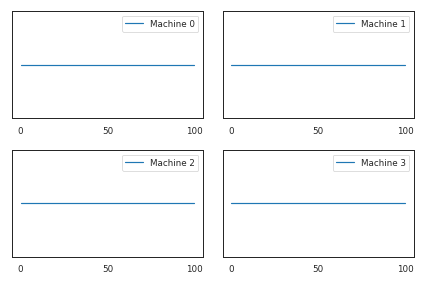

In [27]:
plot(beliefs)

The following function updates our beliefs about one of the machines based on one outcome.

In [28]:
def update(beliefs, i, outcome):
    """Update beliefs about machine i, given outcome.
    
    beliefs: list of Pmf
    i: index into beliefs
    outcome: string 'W' or 'L'
    """
    beliefs[i].update(likelihood_bandit, outcome)

**Exercise 2:** Write a nested loop that plays each machine 10 times; then plot the posterior distributions.  

Hint: call `play` and then `update`.

In [29]:
# Solution goes here
for i in range(4):
    for j in range(10):
        result = play(i)
        beliefs[i].update(likelihood_bandit, result)

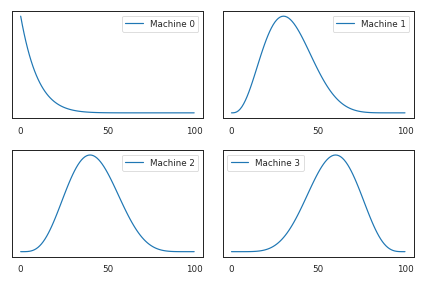

In [30]:
# Solution goes here
plot(beliefs)

After playing each machine 10 times, we can summarize `beliefs` by printing the posterior mean and credible interval:

In [31]:
for i, b in enumerate(beliefs):
    print(b.mean(), b.credible_interval(0.9))

7.883360420960963 [ 0. 23.]
33.33332967399788 [14. 56.]
41.666666663460255 [20. 65.]
58.333333336539745 [35. 80.]


## Bayesian Bandits

To get more information, we could play each machine 100 times, but while we are gathering data, we are not making good use of it.  The kernel of the Bayesian Bandits algorithm is that it collects and uses data at the same time.  In other words, it balances exploration and exploitation.

The following function chooses among the machines so that the probability of choosing each machine is proportional to its "probability of superiority".



In [32]:
def choose(beliefs):
    """Use the Bayesian bandit strategy to choose a machine.
    
    Draws a sample from each distributions.
    
    returns: index of the machine that yielded the highest value
    """
    ps = [b.choice() for b in beliefs]
    return np.argmax(ps)

This function chooses one value from the posterior distribution of each machine and then uses `argmax` to find the index of the machine that chose the highest value.

Here's an example.

In [33]:
choose(beliefs)

3

**Exercise 3:** Putting it all together, fill in the following function to choose a machine, play once, and update `beliefs`:

In [46]:
def choose_play_update(beliefs, verbose=False):
    """Chose a machine, play it, and update beliefs.
    
    beliefs: list of Pmf objects
    verbose: Boolean, whether to print results
    """
    # choose a machine
    machine = choose(beliefs)
    
    # play it
    outcome = play(machine)
    
    # update beliefs
    update(beliefs, machine, outcome)
    
    if verbose:
        print(machine, outcome, beliefs[machine].mean())

In [47]:
# Solution goes here

Here's an example

In [50]:
choose_play_update(beliefs, verbose=True)

3 W 59.99999999715439


## Trying it out

Let's start again with a fresh set of machines and an empty `Counter`.

In [58]:
beliefs = [Pmf.from_seq(prior) for i in range(4)]
counter = Counter()

If we run the bandit algorithm 100 times, we can see how `beliefs` gets updated:

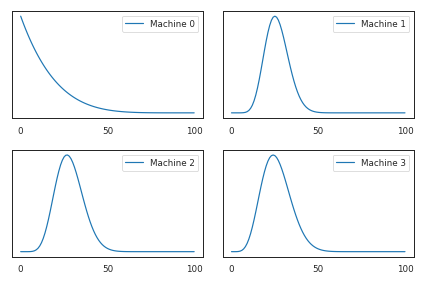

In [59]:
num_plays = 100

for i in range(num_plays):
    choose_play_update(beliefs)
    
plot(beliefs)

We can summarize `beliefs` by printing the posterior mean and credible interval:

In [60]:
for i, b in enumerate(beliefs):
    print(b.mean(), b.credible_interval(0.9))

13.86140728464648 [ 0. 39.]
26.190476190476794 [16. 38.]
28.124999999990372 [16. 42.]
25.9259259270482 [13. 41.]


The credible intervals usually contain the true values (10, 20, 30, and 40).

The estimates are still rough, especially for the lower-probability machines.  But that's a feature, not a bug: the goal is to play the high-probability machines most often.  Making the estimates more precise is a means to that end, but not an end itself.

Let's see how many times each machine got played.  If things go according to plan, the machines with higher probabilities should get played more often.

In [61]:
for machine, count in sorted(counter.items()):
    print(machine, count)

0 5
1 40
2 30
3 25


**Exercise 4:**  Go back and run this section again with a different value of `num_play` and see how it does.

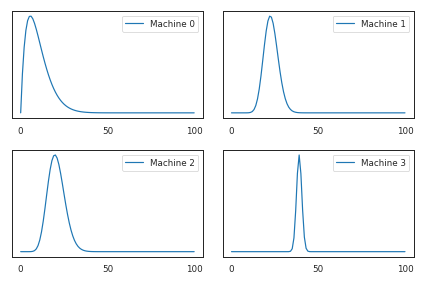

In [63]:
num_plays = 1000

for i in range(num_plays):
    choose_play_update(beliefs)
    
plot(beliefs)

In [64]:
for machine, count in sorted(counter.items()):
    print(machine, count)

0 18
1 103
2 66
3 1013
